## Predicting wages
### Ensemble model

Read the data and sneak a peek into it

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
import pandas as pd
import numpy as np

data = pd.read_csv('wage2015.csv', index_col=False, header=0)
data.head(5)
data.describe()

,wage,lwage,sex,white,black,hisp,shs,hsg,scl,clg,...,health,age,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,0,1,0,0,0,0,0,1,...,1,31,7.0,0.49,0.343,0.2401,3600.0,11,8370.0,18
1,48.076923,3.872802,1,1,0,0,0,0,0,1,...,1,55,31.0,9.61,29.791,92.3521,3050.0,10,5070.0,9
2,11.057692,2.403126,1,1,0,0,0,1,0,0,...,1,38,18.0,3.24,5.832,10.4976,6260.0,19,770.0,4
3,11.538462,2.445686,1,1,0,0,0,0,1,0,...,1,35,13.0,1.69,2.197,2.8561,6050.0,18,170.0,1
4,13.942308,2.634928,0,1,0,0,0,0,0,0,...,0,51,25.0,6.25,15.625,39.0625,420.0,1,6990.0,12


,wage,lwage,sex,white,black,hisp,shs,hsg,scl,clg,...,health,age,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,...,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000,12697.000000
mean,18.145961,2.730945,0.542805,0.696070,0.189179,0.222887,0.064661,0.308734,0.301567,0.236513,...,0.717650,33.703158,12.064897,2.762380,8.145416,27.794773,8440.043554,12.966449,7771.903836,13.266598
std,10.466483,0.625985,0.498184,0.459971,0.391666,0.416200,0.245936,0.461989,0.458956,0.424957,...,0.450161,11.347140,11.431822,4.490614,19.186165,91.651419,19443.325548,6.647292,11658.013997,5.902888
min,0.001923,-6.253829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,170.000000,1.000000
25%,10.576923,2.358675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,25.000000,3.000000,0.090000,0.027000,0.008100,2340.000000,8.000000,4970.000000,9.000000
50%,15.384615,2.733368,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,30.000000,8.000000,0.640000,0.512000,0.409600,4700.000000,15.000000,7380.000000,14.000000
75%,23.237179,3.145754,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,40.000000,19.000000,3.610000,6.859000,13.032100,6220.000000,17.000000,8290.000000,18.000000
max,58.119658,4.062504,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,85.000000,65.500000,42.902500,281.011375,1840.624506,100000.000000,22.000000,100000.000000,23.000000


Correlation between predictors. There are some obvious positive correlations betwen age and experience, wage ad hourly wage. Obvious negative correlations can be seen for mutually excluding categories (data in one category cannot be present in another one). U.S. citizens ("cit") are less likely hispanic and have years of education < 12. Blacks live more in the south ("so") and in central cities ("cent"). 
It seems that there are not too many features strongly correlated with one another.

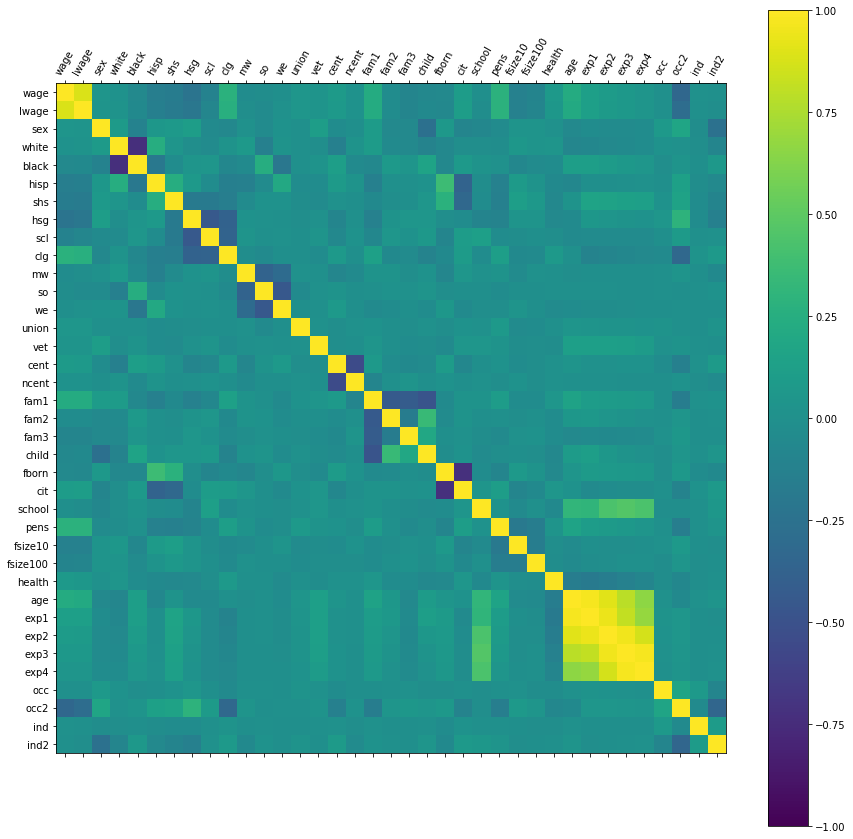

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,data.shape[1],1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns,rotation=60)
ax.set_yticklabels(data.columns)
plt.show();

Data wrangling: one-hot encodings

In [9]:
datay = data.lwage
datax=data.drop(['wage','lwage','occ','occ2','ind','ind2', 'exp2', 'exp3', 'exp4'],axis=1)
#Occupations and industry are categorical. Do one-hot encodings
occ2 = data.loc[:,'occ2']-1 #-1 because min(occ2) is 1, not 0
ind2 = data.loc[:,'ind2']-1 
dataocc2s = pd.get_dummies(occ2,prefix='ocx2',prefix_sep='')
dataind2s = pd.get_dummies(ind2,prefix='int2',prefix_sep='');
datax = pd.concat((datax, dataocc2s,dataind2s), axis=1)
datax.shape
datax.head()

(12697, 73)

,sex,white,black,hisp,shs,hsg,scl,clg,mw,so,...,int213,int214,int215,int216,int217,int218,int219,int220,int221,int222
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fit regression algorithms on train/test data
Split in train and test. The variable of interest y_* is the log hourly wage (lwage column)

In [10]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.4, random_state=0)

Fit a bunch of regression algorithms and compute the MSE ad R$^2$

In [11]:
from sklearn.linear_model import LinearRegression,Lasso,LassoCV,Ridge,RidgeCV,ElasticNet,ElasticNetCV
#from sklearn import neural_network
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics

fitLM = LinearRegression(fit_intercept=1).fit(x_train,y_train)
fitLM.intercept_;fitLM.coef_[50:];
y_predLM = fitLM.predict(x_test);
print("MSE linear model:",metrics.mean_squared_error(y_test, y_predLM))
print("R2 linear model:",metrics.r2_score(y_test, y_predLM))

rLasso = Lasso().fit(x_train,y_train);
y_predLasso = rLasso.predict(x_test);
print("MSE lasso model:",metrics.mean_squared_error(y_test, y_predLasso))
print("R2 lasso model:",metrics.r2_score(y_test, y_predLasso))

rLassoCV = LassoCV().fit(x_train,y_train);
y_predLassoCV = rLassoCV.predict(x_test);
print("MSE lassoCV model:",metrics.mean_squared_error(y_test, y_predLassoCV))
print("R2 lassoCV model:",metrics.r2_score(y_test, y_predLassoCV))

rRidge = Ridge().fit(x_train,y_train);
y_predRidge = rRidge.predict(x_test);
print("MSE Ridge model:",metrics.mean_squared_error(y_test, y_predRidge))
print("R2 Ridge model:",metrics.r2_score(y_test, y_predRidge))

rRidgeCV = RidgeCV().fit(x_train,y_train);
y_predRidgeCV = rRidgeCV.predict(x_test);
print("MSE RidgeCV model:",metrics.mean_squared_error(y_test, y_predRidgeCV))
print("R2 RidgeCV model:",metrics.r2_score(y_test, y_predRidgeCV))

rElasticNet = ElasticNet(l1_ratio=0.5).fit(x_train,y_train);
y_predElasticNet = rElasticNet.predict(x_test);
print("MSE ElasticNet model:",metrics.mean_squared_error(y_test, y_predElasticNet))
print("R2 ElasticNet model:",metrics.r2_score(y_test, y_predElasticNet))

rElasticNetCV = ElasticNetCV().fit(x_train,y_train);
y_predElasticNetCV = rElasticNetCV.predict(x_test);
print("MSE ElasticNetCV model:",metrics.mean_squared_error(y_test, y_predElasticNetCV))
print("R2 ElasticNetCV model:",metrics.r2_score(y_test, y_predElasticNetCV))

rRF = RandomForestRegressor(n_estimators=2000, min_samples_leaf=5).fit(x_train,y_train);
y_predRF = rRF.predict(x_test);
print("MSE RandomForest model:",metrics.mean_squared_error(y_test, y_predRF))
print("R2 RandomForest model:",metrics.r2_score(y_test, y_predRF))

params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 5,
          'learning_rate': 0.01, 'loss': 'ls'};
rBoost = GradientBoostingRegressor(**params).fit(x_train,y_train);
y_predBoost = rBoost.predict(x_test);
print("MSE BoostedTrees model:",metrics.mean_squared_error(y_test, y_predBoost))
print("R2 BoostedTrees model:",metrics.r2_score(y_test, y_predBoost))

28142632370.827576

array([ -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10,  -2.41619256e+10,
        -2.41619256e+10,  -2.41619256e+10])

('MSE linear model:', 0.28779711368868166)
('R2 linear model:', 0.29681560297694387)
('MSE lasso model:', 0.39835294042146496)
('R2 lasso model:', 0.026690821800116393)
('MSE lassoCV model:', 0.29002770810882039)
('R2 lassoCV model:', 0.29136551637869901)
('MSE Ridge model:', 0.28775937591802192)
('R2 Ridge model:', 0.29690780894512159)
('MSE RidgeCV model:', 0.2875878303253096)
('R2 RidgeCV model:', 0.29732695207907189)
('MSE ElasticNet model:', 0.39310644364507075)
('R2 ElasticNet model:', 0.039509764370134537)
('MSE ElasticNetCV model:', 0.29008557669720236)
('R2 ElasticNetCV model:', 0.29122412410444587)
('MSE RandomForest model:', 0.29425592795662914)
('R2 RandomForest model:', 0.2810345641809695)
('MSE BoostedTrees model:', 0.28652303188317302)
('R2 BoostedTrees model:', 0.29992861003487359)


### Ensemble method: Stacking  
With stacked generalization models are combined using another machine learning algorithm. Below I apply linear regression to the prediction from 8 models. Use K-fold cross validation to overcome the problem of using the same training dataset for prediction

In [25]:
from sklearn.model_selection import KFold
base_algorithms = [fitLM,rLasso,rLassoCV,rRidge,rRidgeCV,rElasticNet] #Skip rElasticNetCV,rRF for speed
stacking_train_dataset = pd.DataFrame()

kf = KFold(n_splits=10, shuffle=False, random_state=1)
for i,base_algorithm in enumerate(base_algorithms):
    print("Busy with algorithm {} of {}".format(str(i+1),str(len(base_algorithms))))
    for ind_train, ind_test in kf.split(x_train):
        predi = base_algorithm.fit(x_train.iloc[ind_train], y_train.iloc[ind_train]).predict(x_train.iloc[ind_train])
        stacking_train_dataset = pd.concat([stacking_train_dataset,pd.DataFrame(predi)],axis=1)
    base_algorithm.fit(train).predict(..)
'''    stacking_test_dataset[,i] = base_algorithm.fit(train).predict(test)

final_predictions = combiner_algorithm.fit(stacking_train_dataset, target).predict(stacking_test_dataset)
'''

Busy with algorithm 1 of 4
Busy with algorithm 2 of 4
Busy with algorithm 3 of 4
Busy with algorithm 4 of 4


In [27]:
stacking_model = LinearRegression(fit_intercept=0).fit(stacking_train_dataset,y_train)
stacking_test_dataset = stacking_model.predict(x_test)
stacking_model
y_predStack = stacking_test_dataset
print("MSE stacking model:",metrics.mean_squared_error(y_test, y_predStack))
print("R2 stacking model:",metrics.r2_score(y_test, y_predStack))

#0.28779671489314629
#0.29681657736752931

LinearRegression(copy_X=True, fit_intercept=0, n_jobs=1, normalize=False)

('MSE stacking model:', 0.28779671489314629)
('R2 stacking model:', 0.29681657736752931)


### Ensemble method: Linear Fitting

In [ ]:
#There is something wrong with this linear model in scikitlearn
x_Ens=np.column_stack((y_predLM, y_predLasso,y_predElasticNet,y_predRF,y_predBoost))
x_EnsConst=np.hstack((x_Ens,np.ones((len(x_Ens),1))))
fitEnsLM = LinearRegression(fit_intercept=0).fit(x_EnsConst,y_test)
#fitEnsLM.intercept_
fitEnsLM.coef_
#y_predEnsLM = fitEnsLM.predict(x_test)
#print "MSE ensamble linear model:",np.mean((y_test - y_predEnsLM) ** 2)     #MSE 
#print "R2 ensamble  linear model:", 1 - np.sum((y_test - y_predEnsLM) ** 2)/np.sum((y_test - np.mean(y_test))**2) #R2


Ensemble model: linear fit  (statsmodels)

In [ ]:
import statsmodels.discrete.discrete_model as sm
from statsmodels.api import add_constant
x_Ens=np.column_stack((y_predLM, y_predLasso,y_predElasticNet,y_predRF,y_predBoost))
x_Ens=np.column_stack((y_predLM,y_predLasso,y_predLassoCV,y_predRidge,y_predRidgeCV, y_predElasticNet,y_predRF,y_predBoost))
#Same Linear Model thing using statsmodels
x_EnsConst=add_constant(x_Ens,prepend = False)
result = sm.OLS(y_test, x_EnsConst).fit()   #Linear model on train data
print(result.summary())
y_predEnsLM = result.predict(x_EnsConst)
print("MSE ensamble linear model:",metrics.mean_squared_error(y_test, y_predEnsLM))
print("R2 ensamble linear model:",metrics.r2_score(y_test, y_predEnsLM))

Lasso does not converge, probably because there are too little methods 

In [ ]:
lasso = Lasso(alpha=1).fit(x_Ens,y_test)
y_predEnsLasso = lasso.predict(x_Ens)
lasso.intercept_
lasso.coef_
print "MSE lasso model:",metrics.mean_squared_error(y_test, y_predLasso)
print "R2 lasso model:",metrics.r2_score(y_test, y_predLasso)

Ensemble model: lasso fitting - Cannot make it work :(

In [ ]:
import statsmodels.regression as lm
lasso = lm.linear_model.OLS.fit_regularized(L1_wt=1)
resultLasso=lasso.fit(x_Ens,y_test)
y_predEnsLasso = resultLasso.predict(x_Ens)
resultLasso.coef_
print "MSE ensamble lasso model:",metrics.mean_squared_error(y_test, y_predEnsLasso)
print "R2 ensamble lasso model:",metrics.r2_score(y_test, y_predEnsLasso)